In [2]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

# Data Processing

In [3]:
df = pd.read_csv('titanic/train.csv', index_col=0)
val_df = pd.read_csv('titanic/test.csv', index_col=0)
def process_data(df):
    df.Sex = pd.Categorical(df.Sex)
    df.Sex = df.Sex.cat.codes
    df.Age.fillna(df.Age.mean(), inplace=True)
    df.Cabin = df.Cabin.fillna('X').apply(lambda x: x[0])
    df = pd.concat([df, df.Cabin.str.get_dummies()], axis=1)
    df = pd.concat([df, pd.get_dummies(data=df.Embarked, prefix='EMB_')], axis=1)
    df.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked'], inplace=True, errors='ignore')
    return df

df = process_data(df)
val_df = process_data(val_df) # to jest trochę źle test_df.Age.fillna(train_df.Age.mean())

# Modelling

In [4]:
from sklearn.model_selection import train_test_split

y = df.pop('Survived')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
X_val = val_df

In [5]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
model.fit(X_train, y_train)
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
train_acc, test_acc

(0.8683788121990369, 0.7723880597014925)

In [6]:
model.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': 5,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'feature_names_in_': array(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'A', 'B', 'C',
        'D', 'E', 'F', 'G', 'T', 'X', 'EMB__C', 'EMB__Q', 'EMB__S'],
       dtype=object),
 'n_features_in_': 18,
 'n_outputs_': 1,
 'classes_': array([0, 1], dtype=int64),
 'n_classes_': 2,
 'max_features_': 18,
 'tree_': <sklearn.tree._tree.Tree at 0x19b8b5edd10>}

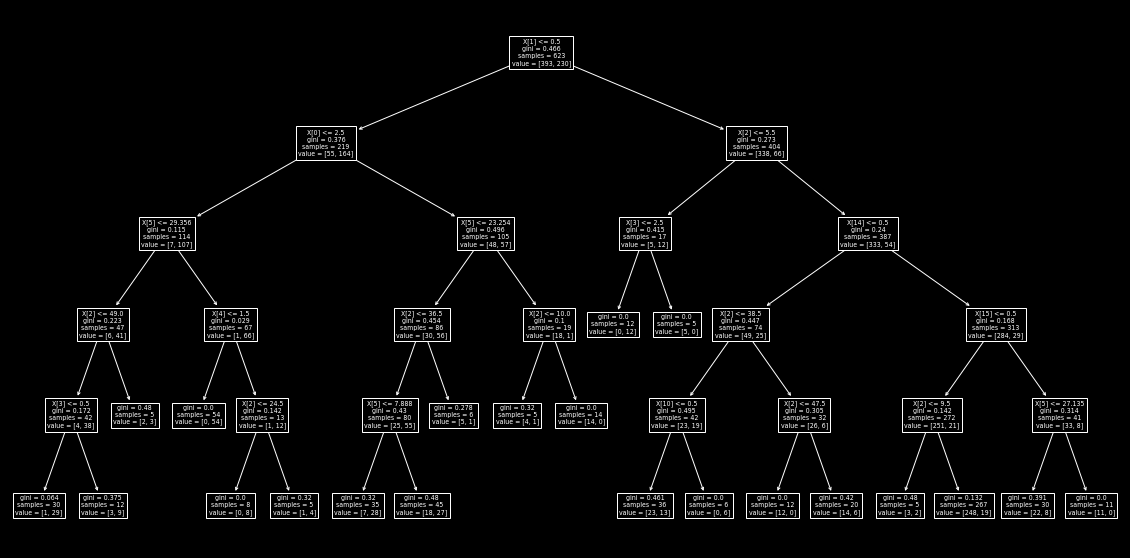

In [7]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure

figure(figsize=(20, 10))
plot_tree(model)
plt.show()

# Crossvalidation

In [8]:
from sklearn.model_selection import GridSearchCV

param_space = {
    'min_samples_leaf': range(1, 10), 
    'max_depth': range(1, 10)
}
model = DecisionTreeClassifier()
gs = GridSearchCV(model, param_space)
gs.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 10)})

In [9]:
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').iloc[1, 4:]

param_max_depth                                                 5
param_min_samples_leaf                                          4
params                    {'max_depth': 5, 'min_samples_leaf': 4}
split0_test_score                                           0.824
split1_test_score                                            0.88
split2_test_score                                           0.792
split3_test_score                                        0.887097
split4_test_score                                        0.822581
mean_test_score                                          0.841135
std_test_score                                           0.036538
rank_test_score                                                 1
Name: 39, dtype: object

# DoDOmu

- dodać do X_val brakujące featurey
- zrobić predict i zapisać wyniki to pliku titanic/submission.csv
- wrzucić to na kaggla (sprawdzić jaka jest komenda kaggle submission .... titanic/submission.csv) + dodać ją do README.md

In [10]:
X_val['T'] = X_train['T'].mean()

In [11]:
import numpy as np

X_val = X_val[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X', 'EMB__C', 'EMB__Q', 'EMB__S']]
np.any(np.isnan(X_val))

# X_val.dropna(inplace=True)
X_val['Fare'] = X_val['Fare'].fillna(X_train['Fare'].mean())

pd.set_option("display.max_rows", None, "display.max_columns", None)
display(X_val)

predicted_df = gs.predict(X_val)
# model.fit(X_train, y_train)
# model.predict(X_val)

#predicted_df['PassengerId'] = X_val.index
#predicted_df['id'] = X_val.index
submission_df = pd.DataFrame({'Survived': X_val.index}, index=X_val.index)
submission_df['Survived'] = predicted_df
submission_df

submission_df.to_csv('submission.csv')

,Pclass,Sex,Age,SibSp,Parch,Fare,A,B,C,D,E,F,G,T,X,EMB__C,EMB__Q,EMB__S
PassengerId,,,,,,,,,,,,,,,,,,
892,3,1,34.50000,0,0,7.82920,0,0,0,0,0,0,0,0.001605,1,0,1,0
893,3,0,47.00000,1,0,7.00000,0,0,0,0,0,0,0,0.001605,1,0,0,1
894,2,1,62.00000,0,0,9.68750,0,0,0,0,0,0,0,0.001605,1,0,1,0
895,3,1,27.00000,0,0,8.66250,0,0,0,0,0,0,0,0.001605,1,0,0,1
896,3,0,22.00000,1,1,12.28750,0,0,0,0,0,0,0,0.001605,1,0,0,1
897,3,1,14.00000,0,0,9.22500,0,0,0,0,0,0,0,0.001605,1,0,0,1
898,3,0,30.00000,0,0,7.62920,0,0,0,0,0,0,0,0.001605,1,0,1,0
899,2,1,26.00000,1,1,29.00000,0,0,0,0,0,0,0,0.001605,1,0,0,1
900,3,0,18.00000,0,0,7.22920,0,0,0,0,0,0,0,0.001605,1,1,0,0
